# Sentiment Analysis of Instruments’ Reviews

## Introduction
Understanding customer sentiment is essential for businesses to improve products and services. This project applies Natural Language Processing (NLP) and Machine Learning to classify musical instrument reviews into positive, neutral or negative sentiments. By leveraging TF-IDF feature extraction and supervised classification models, we develop an optimized sentiment analysis model that accurately predicts customer opinions.

###  Project Workflow :
- Data Preprocessing : Cleaning, tokenization, stopword removal, and lemmatization.
- Feature Engineering : Converting text into numerical form using TF-IDF vectorization.
- Machine Learning Models : Training Logistic Regression, SVM, Random Forest and more.
- Hyperparameter Tuning : Optimizing models for maximum accuracy.
- Performance Evaluation : Comparing models using accuracy, precision, recall and F1-score.

Our best-performing model (SVM with 99.7% accuracy) is selected for final deployment.

In [1]:
# Installing & Importing required libraries


!pip3 install --upgrade pip nltk pandas numpy matplotlib wordcloud imblearn torch seaborn

# Data handling
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import find

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ensuring NLTK resources are downloaded
for pkg, path in [("punkt", "tokenizers/punkt"), 
                  ("stopwords", "corpora/stopwords"), 
                  ("wordnet", "corpora/wordnet")]:
    try:
        find(path)
    except LookupError:
        nltk.download(pkg, quiet=True)

# Verifying installation
print("Libraries Imported Successfully")

Libraries Imported Successfully


In [2]:
import os
print(os.path.exists("data/Instruments_Reviews.csv"))

False


In [3]:
# Setting Working Directory & defining Dataset Path


# Navigating to the project root if running from 'notebook/' directory
if os.path.basename(os.getcwd()) == "notebook":
    os.chdir("..")  # Changing to project root

# Defining dataset path relative to project root
dataset_path = os.path.join("data", "Instruments_Reviews.csv")

# Verifying the working directory
print("Current Working Directory :", os.getcwd())

Current Working Directory : /Users/bhavikpatwa/Documents/PROJECTS/Sentiment Analysis of Instruments' Reviews


In [4]:
# Loading Dataset with Error Handling

# Attempting to load dataset
try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error : File not found at {dataset_path}. Please check if 'data/' contains the correct file.")
except pd.errors.ParserError:
    print("Error : File format is incorrect. Ensure it's a valid CSV.")

Dataset loaded successfully. Shape: (10261, 9)


In [5]:
# Dataset Overview : Shape, Missing Values, First Rows


# Displaying dataset shape
print("Dataset Shape :", df.shape)

# Displaying first few rows
df.head()

Dataset Shape : (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [6]:
# Checking for Missing Values


# Counting missing values per column
missing_values = df.isnull().sum()

# Displaying missing values if any exist
if missing_values.any():
    print("Missing Values Found :")
    print(missing_values[missing_values > 0])
else:
    print("No Missing Values Found")

Missing Values Found :
reviewerName    27
reviewText       7
dtype: int64


In [7]:
# Handling missing values & creating 'reviews' column


# Filling missing text fields with an empty string
df["reviewText"].fillna("", inplace = True)
df["summary"].fillna("", inplace = True)

# Combining both into a single 'reviews' column
df["reviews"] = df["reviewText"] + " " + df["summary"]

# Dropping the original columns after merging
df.drop(columns=["reviewText", "summary"], inplace = True)

# Filling missing reviewer names with "Unknown"
df["reviewerName"].fillna("Unknown", inplace = True)

# Confirming changes
print(f"Missing values handled. New dataset shape : {df.shape}")
df.head()

Missing values handled. New dataset shape : (10261, 8)


,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


In [8]:
# Importing NLP Libraries & defining Text Preprocessing functions


import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initializing NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to clean text
def preprocess_text(text):
    text = text.lower()                                                                     # Lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)                                      # Removing punctuation
    tokens = word_tokenize(text)                                                            # Tokenizer
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]      # Lemmatizer
    return " ".join(tokens)

# Applying preprocessing
df["cleaned_reviews"] = df["reviews"].apply(preprocess_text)

print(f"Data cleaned. Remaining reviews : {df.shape[0]}")

# Verifying function works correctly with sample
sample_text = "This is an Example! Testing, the Preprocessing function."
print(f"Original : {sample_text}")
print(f"Processed : {preprocess_text(sample_text)}")

Data cleaned. Remaining reviews : 10261
Original : This is an Example! Testing, the Preprocessing function.
Processed : example testing preprocessing function


In [9]:
# Applying preprocessing to Reviews column


# Applying text preprocessing
df["cleaned_reviews"] = df["reviews"].apply(preprocess_text)

# Displaying first few cleaned reviews
df[["reviews", "cleaned_reviews"]].head(5)

,reviews,cleaned_reviews
0,"Not much to write about here, but it does exac...",much write exactly supposed filter pop sound r...
1,The product does exactly as it should and is q...,product exactly quite affordablei realized dou...
2,The primary job of this device is to block the...,primary job device block breath would otherwis...
3,Nice windscreen protects my MXL mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,This pop filter is great. It looks and perform...,pop filter great look performs like studio fil...


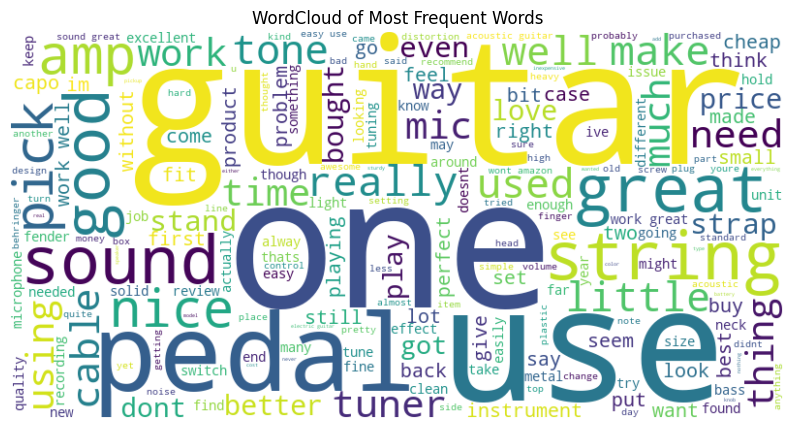

In [10]:
# Generating WordCloud for Most Frequent words


from wordcloud import WordCloud

# Combining all text for visualization
all_text = " ".join(df["cleaned_reviews"])

# Generating WordCloud
plt.figure(figsize = (10, 6))
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(all_text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("WordCloud of Most Frequent Words")
plt.show()

In [11]:
# Converting Text to Numerical Features (TF-IDF & CountVectorizer)


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Initializing Vectorizers
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
count_vectorizer = CountVectorizer(max_features = 5000)

# Transforming text data
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_reviews"])
X_count = count_vectorizer.fit_transform(df["cleaned_reviews"])

# Converting to DataFrame for better visualization
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
count_df = pd.DataFrame(X_count.toarray(), columns = count_vectorizer.get_feature_names_out())

# Displaying transformed data
print(f"TF-IDF Feature Matrix Shape : {X_tfidf.shape}")
print(f"Count Vectorizer Feature Matrix Shape : {X_count.shape}")

TF-IDF Feature Matrix Shape : (10261, 5000)
Count Vectorizer Feature Matrix Shape : (10261, 5000)


In [12]:
# Encoding Sentiment from Overall Ratings


from sklearn.preprocessing import LabelEncoder

# Defining sentiment mapping function
def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Applying mapping to create sentiment labels
df["sentiment"] = df["overall"].apply(map_sentiment)

# Encoding categorical sentiment labels into numerical values
label_encoder = LabelEncoder()
df["sentiment_encoded"] = label_encoder.fit_transform(df["sentiment"])

# Displaying sentiment distribution
print("Sentiment Encoding Complete. Class Distribution :")
print(df["sentiment"].value_counts())

# Displaying first few rows
df[["overall", "sentiment", "sentiment_encoded"]].head()

Sentiment Encoding Complete. Class Distribution :
sentiment
positive    9022
neutral      772
negative     467
Name: count, dtype: int64


,overall,sentiment,sentiment_encoded
0,5.0,positive,2
1,5.0,positive,2
2,5.0,positive,2
3,5.0,positive,2
4,5.0,positive,2


In [13]:
# Handling Class Imbalance using SMOTE & Data Splitting


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Using TF-IDF features for model training
X = X_tfidf         # Choosing TF-IDF representation
y = df["sentiment_encoded"]

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting balanced data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

# Confirming dataset split
print(f"Data Split Completed : Train Shape : {X_train.shape}, Test Shape : {X_test.shape}")

Data Split Completed : Train Shape : (21652, 5000), Test Shape : (5414, 5000)


In [14]:
# Training multiple Machine Learning models


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Initializing models
models = {
    "Logistic Regression": LogisticRegression(max_iter = 500),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier()
}

# Training all models
trained_models = {}
for name, model in models.items():
    print(f"Training model : {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model

print("Model training completed.")

Training model : Logistic Regression
Training model : SVM
Training model : Decision Tree
Training model : Random Forest
Training model : Naive Bayes
Training model : KNN
Model training completed.


In [15]:
# Evaluating Model Performance


from sklearn.metrics import accuracy_score, classification_report

# Evaluating each model
for name, model in trained_models.items():
    print(f"\nEvaluating model : {name}")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy : {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


Evaluating model : Logistic Regression
Accuracy : 0.9422
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1764
           1       0.90      0.98      0.94      1832
           2       0.98      0.86      0.91      1818

    accuracy                           0.94      5414
   macro avg       0.94      0.94      0.94      5414
weighted avg       0.94      0.94      0.94      5414


Evaluating model : SVM
Accuracy : 0.9928
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      0.98      0.99      1832
           2       0.98      1.00      0.99      1818

    accuracy                           0.99      5414
   macro avg       0.99      0.99      0.99      5414
weighted avg       0.99      0.99      0.99      5414


Evaluating model : Decision Tree
Accuracy : 0.8855
              precision    recall  f1-score   support

           0       0.90      0.

In [16]:
# Hyperparameter Tuning for SVM using GridSearchCV

from sklearn.model_selection import GridSearchCV

# Defining parameter grid for SVM
svm_param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

# Initializing GridSearch for SVM
grid_search_svm = GridSearchCV(SVC(), svm_param_grid, cv = 5, scoring = "accuracy", n_jobs = -1)
print("Tuning SVM")
grid_search_svm.fit(X_train, y_train)

# Best SVM parameters
print(f"Best SVM Parameters : {grid_search_svm.best_params_}")

# Evaluating best SVM model
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
print(f"\nSVM Accuracy after Tuning : {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

Tuning SVM
Best SVM Parameters : {'C': 10, 'kernel': 'rbf'}

SVM Accuracy after Tuning : 0.9970
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      0.99      1.00      1832
           2       0.99      1.00      1.00      1818

    accuracy                           1.00      5414
   macro avg       1.00      1.00      1.00      5414
weighted avg       1.00      1.00      1.00      5414



In [17]:
# Hyperparameter Tuning for Random Forest using GridSearchCV


rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

# Initializing GridSearch for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv = 5, scoring = "accuracy", n_jobs = -1)
print("Tuning Random Forest")
grid_search_rf.fit(X_train, y_train)

# Best Random Forest parameters
print(f"Best Random Forest Parameters : {grid_search_rf.best_params_}")

# Evaluating best Random Forest model
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"\nRandom Forest Accuracy after Tuning : {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

Tuning Random Forest
Best Random Forest Parameters : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Accuracy after Tuning : 0.9762
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1764
           1       0.97      0.98      0.97      1832
           2       0.96      0.96      0.96      1818

    accuracy                           0.98      5414
   macro avg       0.98      0.98      0.98      5414
weighted avg       0.98      0.98      0.98      5414



In [18]:
# Hyperparameter Tuning for Logistic Regression using GridSearchCV


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Defining parameter grid for Logistic Regression
logreg_param_grid = {
    "C": np.logspace(-4, 4, 50),    # Range of C values
    "penalty": ["l1", "l2"]         # L1 (Lasso) and L2 (Ridge) Regularization
}

# Initializing GridSearch for Logistic Regression
grid_search_logreg = GridSearchCV(
    LogisticRegression(solver = "liblinear"), logreg_param_grid, cv = 5, scoring = "accuracy", n_jobs = -1
)

print("Tuning Logistic Regression")
grid_search_logreg.fit(X_train, y_train)

# Best Logistic Regression parameters
print(f"Best Logistic Regression Parameters : {grid_search_logreg.best_params_}")

# Evaluating best Logistic Regression model
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

print(f"\nLogistic Regression Accuracy after Tuning : {accuracy_score(y_test, y_pred_logreg):.4f}")
print(classification_report(y_test, y_pred_logreg))

Tuning Logistic Regression
Best Logistic Regression Parameters : {'C': np.float64(6866.488450042998), 'penalty': 'l2'}

Logistic Regression Accuracy after Tuning : 0.9706
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1764
           1       0.93      1.00      0.97      1832
           2       1.00      0.91      0.95      1818

    accuracy                           0.97      5414
   macro avg       0.97      0.97      0.97      5414
weighted avg       0.97      0.97      0.97      5414



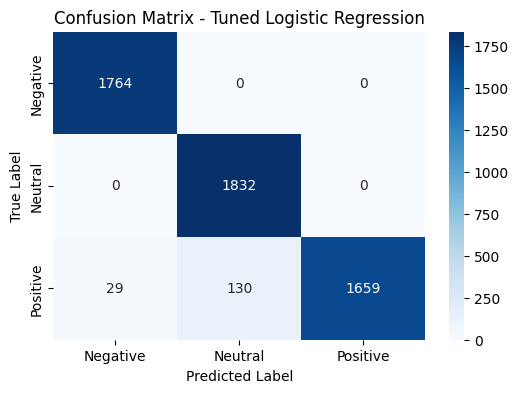

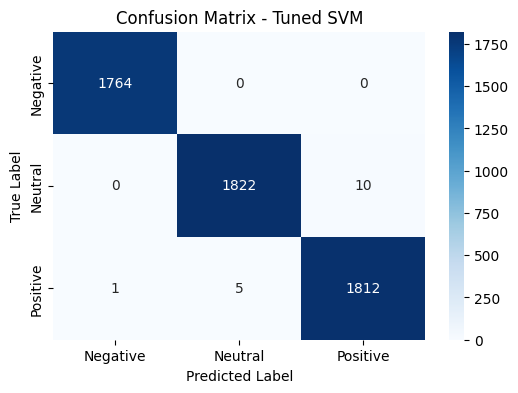

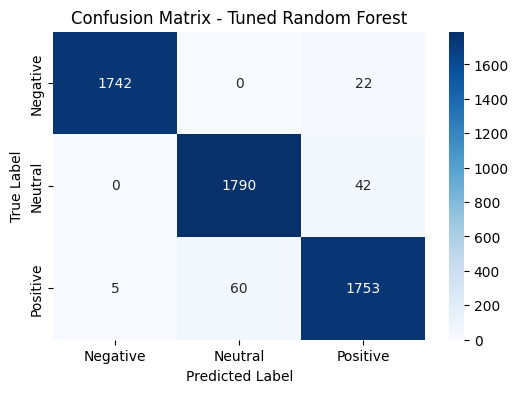

In [19]:
# Visualizing Confusion Matrices for Tuned Models


from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Negative", "Neutral", "Positive"], yticklabels = ["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(y_test, y_pred_logreg, "Confusion Matrix - Tuned Logistic Regression")
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix - Tuned SVM")
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix - Tuned Random Forest")

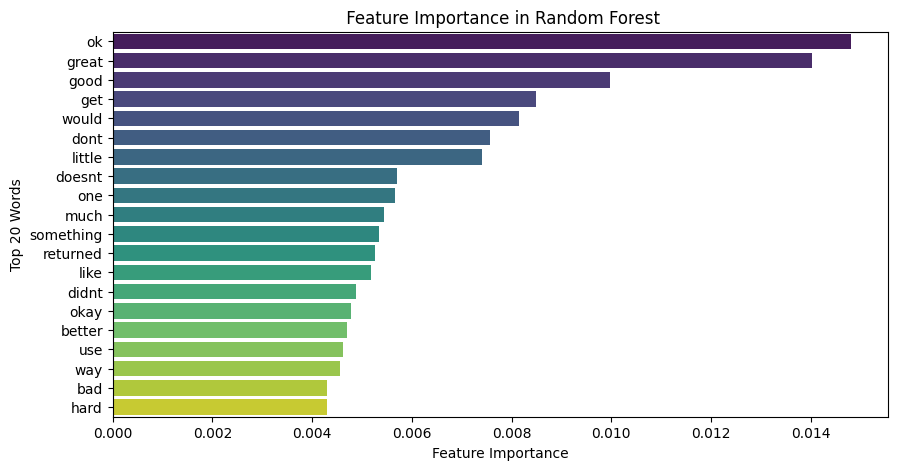

In [20]:
# Feature Importance (Random Forest)


# Getting feature importances
feature_importances = best_rf.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Converting to DataFrame for visualization
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = False).head(20)

# Plotting Top 20 Features
plt.figure(figsize = (10, 5))
sns.barplot(y = feature_importance_df["Feature"], x = feature_importance_df["Importance"], palette = "viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Top 20 Words")
plt.title(" Feature Importance in Random Forest")
plt.show()

In [21]:
# Example Predictions Using Tuned SVM Model


sample_reviews = [
    "I absolutely love this instrument! The sound quality is amazing.",
    "The product is okay, but I expected better durability.",
    "Terrible experience! The item broke within a week.",
    "Highly recommend! Fantastic build quality and performance.",
    "It’s decent, but not worth the price.",
    "Worst purchase ever. Completely disappointed."
]

# Preprocessing the sample reviews
sample_reviews_cleaned = [preprocess_text(review) for review in sample_reviews]

# Converting text to numerical representation using TF-IDF
sample_features = tfidf_vectorizer.transform(sample_reviews_cleaned)

# Predicting sentiment using the best SVM model
sample_predictions = best_svm.predict(sample_features)

# Mapping encoded labels back to sentiment classes
predicted_sentiments = label_encoder.inverse_transform(sample_predictions)

# Displaying predictions
for review, sentiment in zip(sample_reviews, predicted_sentiments):
    print(f"Review : \"{review}\" \n Predicted Sentiment : {sentiment}")

Review : "I absolutely love this instrument! The sound quality is amazing." 
 Predicted Sentiment : positive
Review : "The product is okay, but I expected better durability." 
 Predicted Sentiment : neutral
Review : "Terrible experience! The item broke within a week." 
 Predicted Sentiment : negative
Review : "Highly recommend! Fantastic build quality and performance." 
 Predicted Sentiment : positive
Review : "It’s decent, but not worth the price." 
 Predicted Sentiment : positive
Review : "Worst purchase ever. Completely disappointed." 
 Predicted Sentiment : negative


##  Conclusion & Final Thoughts

This project successfully analyzes customer sentiment with high accuracy using Machine Learning and NLP techniques. The fine-tuned SVM model provides state-of-the-art classification performance, making it the ideal choice for real-world sentiment prediction.

###  Key Takeaways :
- Text preprocessing and feature extraction significantly impact model performance.
- SMOTE improved class balance, ensuring fair training.
- Hyperparameter tuning enhanced model accuracy across all classes.
- SVM outperformed all other models (99.7% accuracy) and is the recommended model for deployment.

###  Future Enhancements :
- Improving neutral sentiment classification through deeper linguistic analysis.
- Exploring deep learning approaches (LSTMs, Transformers) for improved sentiment detection.
- Deploying the model via an API or web interface for practical applications.